In [2]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import fannypack

In [3]:
class FullCovGaussianLayer(nn.Module):
    def __init__(
        self, 
        input_dim, 
        output_dim, 
        prior_var = 0.8, 
        pre_trained_values = None,
        gamma = torch.tensor([1.0])
    ):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gamma = gamma
        # Prior parameters p(theta)

        # If no prior parameters are given, set them to zero mean and given variance
        if pre_trained_values is None:
            self.mu_p = torch.zeros(input_dim * output_dim + output_dim)
            self.chol_p = torch.eye(input_dim * output_dim + output_dim) * torch.sqrt(torch.tensor(prior_var))
            
        else:
            # Extract pre-trained values
            w_pre_mean = pre_trained_values[0]
            w_pre_log_var = pre_trained_values[1]
            b_pre_mean = pre_trained_values[2]
            b_pre_log_var = pre_trained_values[3]

            # Set priors to pre-trained values
            self.mu_p = torch.cat([w_pre_mean, b_pre_mean], dim=0)
            combined_log_vars = torch.cat([w_pre_log_var, b_pre_log_var], dim=0)
            self.chol_p = torch.diag(torch.exp(combined_log_vars / 2))
           

         # Variational parameters q(theta)
        self.mu_q = self.mu_p.clone()
        self.chol_q = self.chol_p.clone()

        self.lambda_1 = torch.linalg.inv(self.chol_q @ self.chol_q.t()) @ self.mu_q


    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p(self):
        """Weight prior distribution"""
        return torch.distributions.MultivariateNormal(self.mu_p, scale_tril=self.chol_p)

    def q(self):
        """Variational weight posterior"""
        return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=self.chol_q)

    
    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        return torch.distributions.kl_divergence(self.q(), self.p()).sum()
    
    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim
        num_samples = x.shape[0]

        # Sample the parameters and detach them from the hyperparameters graph
        param_sample = self.q().rsample((num_samples,)).detach().requires_grad_()
        weights = param_sample[:,:self.input_dim * self.output_dim]  # Shape: (num_samples, input_dim * output_dim)
        weights = weights.view(num_samples, self.input_dim, self.output_dim)  # Reshape to (num_samples, input_dim, output_dim)

        biases = param_sample[:,self.input_dim * self.output_dim:].unsqueeze(1)  # Shape: (output_dim, num_samples)

        return x @ weights + biases, param_sample


    def update_layer(self, grads, alpha = 0.001):
        """Updates the variational parameters of the layer"""
        grad = grads.mean(0)
        chol_scaled = torch.sqrt(torch.tensor(1 / (1 - alpha * self.gamma))) * self.chol_q # chol_tilde is scaled by sqrt of sigma_tilde scaling
        v = chol_scaled @ (chol_scaled.t() @ grad) # sigma_tilde @ g
        weight = - alpha / (1 + alpha * grad.t() @ v) # weight of rank-one update

        # Perform rank-one update of the Cholesky factor - computes cholesky of LL^T + weight * vv^T
        self.chol_q = fannypack.utils.cholupdate(chol_scaled, v, weight)

        nu = grad.t() @ self.mu_q
        self.lambda_1 = (1 - alpha*self.gamma) * self.lambda_1 - alpha*(1 - nu) * grad
        self.mu_q = self.chol_q @ (self.chol_q.t() @ self.lambda_1)


In [4]:
class RouBLBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""
    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std=1.0,
        prior_var = 0.8,
        pre_trained_values = None,
        gamma = torch.tensor([1])
    ):
        super(RouBLBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_std = noise_std
        self.gamma = gamma
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            # If no pre trained parameters are given, set them to zero mean and given variance
            if pre_trained_values is None:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var, gamma = self.gamma))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var, gamma = self.gamma)
                    )
                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var, gamma = self.gamma)
                    )
                    self.network.append(self.activation) 

            # Set to pre trained values
            else:
                if i == 0:
                    self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i], pre_trained_values = pre_trained_values[i], gamma = self.gamma))
                    self.network.append(self.activation)
                elif i == len(hidden_dims):
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim, pre_trained_values = pre_trained_values[i], gamma = self.gamma)
                    )
                else:
                    self.network.append(
                        FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i], pre_trained_values = pre_trained_values[i], gamma = self.gamma)
                    )
                    self.network.append(self.activation)

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        all_param_samples = []  # To store param_sample for each layer

        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, FullCovGaussianLayer):
                x, param_sample = layer(x)
                all_param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, all_param_samples
    
    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, self.noise_std)
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()
    
    def prior_log_prob(self, all_param_samples):
        """Computes the log prior probability of the network weights"""
        log_prob = 0
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):

                log_prob += layer.p().log_prob(all_param_samples[i//2]).mean(0)  # p() will handle the batch automatically
       
        return log_prob


    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl_divergence() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])
    

    def loss(self, x, y, num_samples = 1):
        y_pred, all_param_samples = self.forward(x, num_samples = num_samples)
        exp_ll = self.ll(y, y_pred, num_samples = num_samples)
        prior_log_prob = self.prior_log_prob(all_param_samples)
        kl = self.kl()

        return - exp_ll - self.gamma * prior_log_prob, all_param_samples, exp_ll, kl
    
    def update(self, x, y, num_samples = 1, alpha = 0.001):

        loss, all_param_samples, _, _ = self.loss(x, y, num_samples = num_samples)
        loss.backward()
        grads = [param_sample.grad for param_sample in all_param_samples]
        
        # Update layers
        # with torch.no_grad():  # Disable gradient tracking for parameter updates
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                layer.update_layer(grads[i//2], alpha = alpha)
        return all_param_samples, grads

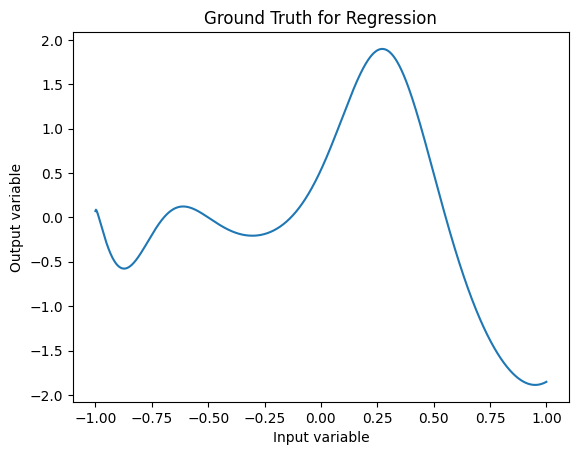

In [5]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

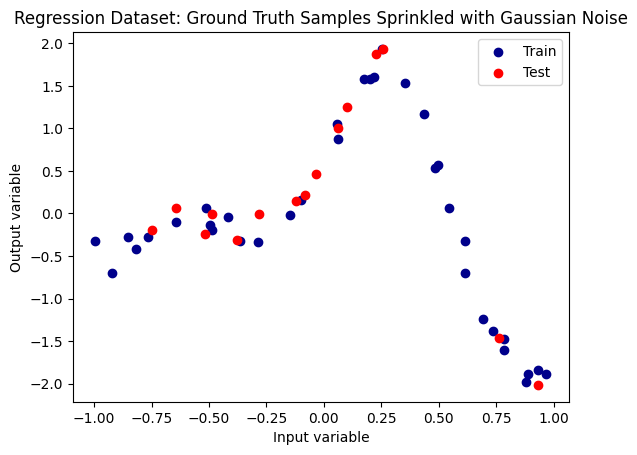

In [6]:
def generate_dataset(size=50, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [7]:
# I'm not sure what gamma should be 
BNN = RouBLBNN(1, [4, 4], 1, noise_std=0.15, prior_var = 0.3, gamma = 1) #, pre_trained_values=pre_trained_values)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(BNN)


RouBLBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): FullCovGaussianLayer()
    (1): ELU(alpha=1.0)
    (2): FullCovGaussianLayer()
    (3): ELU(alpha=1.0)
    (4): FullCovGaussianLayer()
  )
)


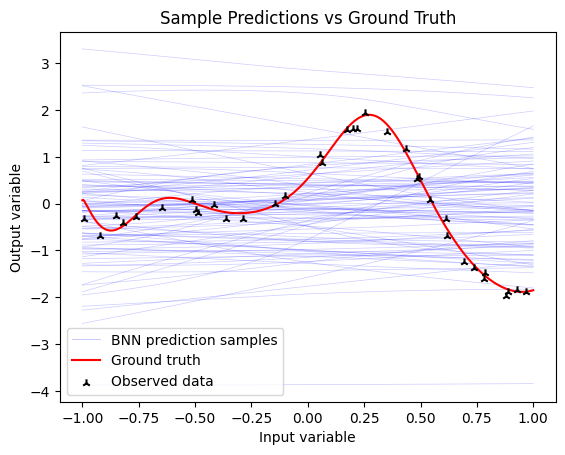

In [8]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = BNN(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:50<00:00, 19.68it/s]


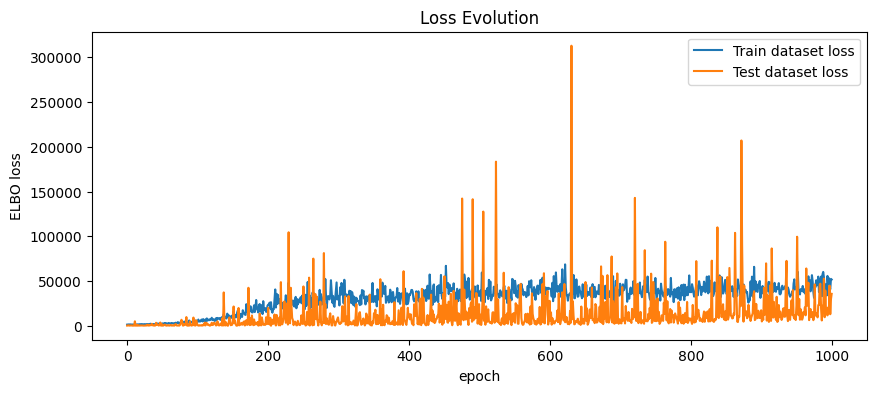

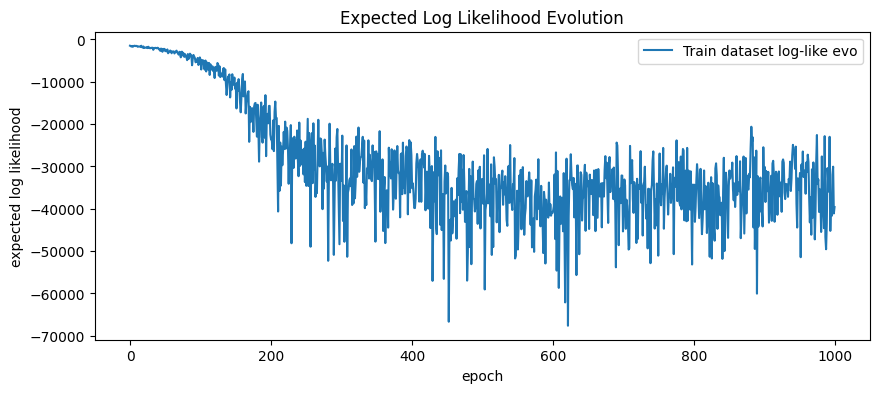

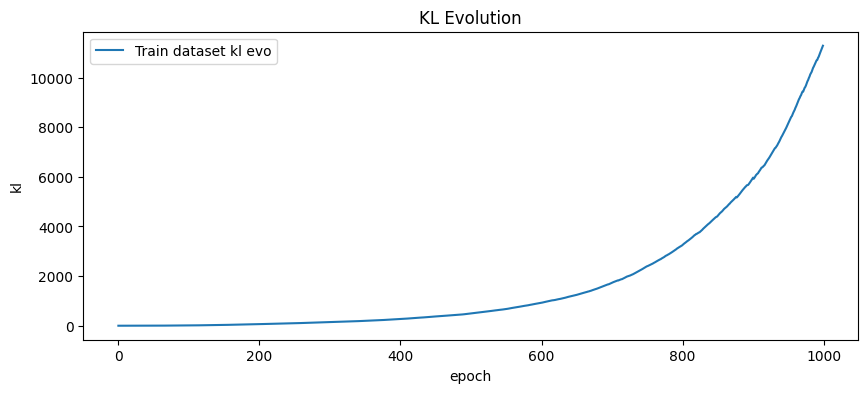

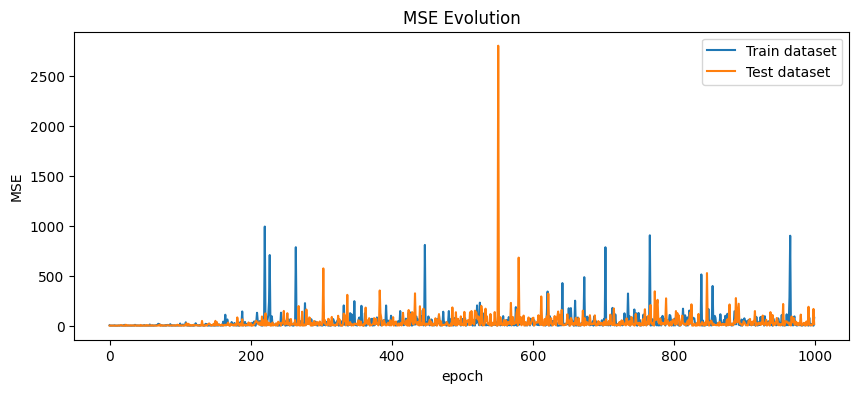

In [9]:
## Train RouBLBNN
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(1000)):  # epochs
    l, _, ll, kl = BNN.loss(x_tr, y_tr, num_samples = 100)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(BNN(x_tr)[0], y_tr.unsqueeze(0)).item())

    te_loss_evo.append(BNN.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(BNN(x_te)[0], y_te.unsqueeze(0)).item())

    BNN.update(x_tr, y_tr, num_samples = 1000, alpha = 0.01)

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

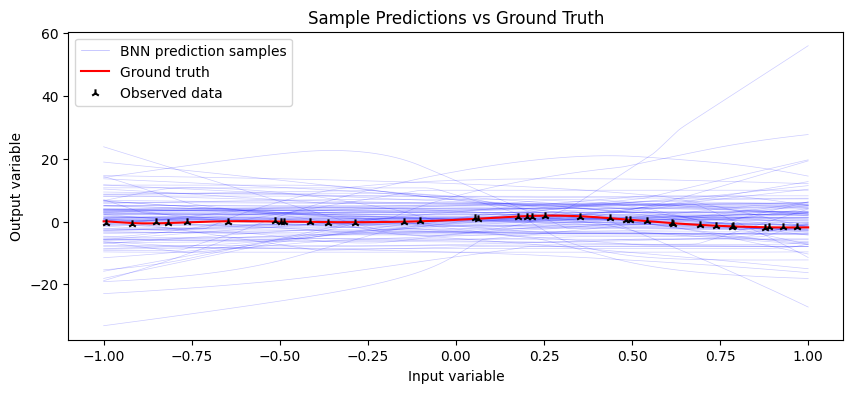

In [10]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = BNN(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()